Code for project: Extragalactic Confusion Foreground
==

1. Catagorization for Potential Gravitational Sources(GWGC);
2. Compute GW power spectrum for baseline galaxies;
3. Compute extragalactic GW confusion foreground. 

Part 1: Catagorization of GWGC
===

In [11]:
# ================
# Import GWGC Data
# ================

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.table import Table, join, vstack
from astropy.io import ascii
import GW_calcs
import MW_maker

data_path = './DATA/'
data_save_path = './generated_data/'

# Import GWGC Data
GWGC = fits.open(data_path + 'VII_267_gwgc.dat.gz.fits')
GWGC = Table.read(data_path + 'VII_267_gwgc.dat.gz.fits')

# Select useful data with Bmag
mask = GWGC['Bmag'] != 0
GWGC = GWGC[mask]

# Adding two columns for M-to-L and Estimated Mass
GWGC['M_to_L'] = np.zeros(len(GWGC)) - 1
GWGC['EST_M'] = np.zeros(len(GWGC)) - 1

In [2]:
# ==============================
# Estimating Galaxy Stellar Mass
# ==============================
'''
Applying mass-to-light ratio condtion to the catalog data from 
Faber and Gallagher (1979).
'''

# Catagorization of galaxies
# Devide GWGC catalog to 7 groups of galaxy following Faber (1979)
mask_mk = GWGC['TT'] == -9
GWGC_mk = GWGC[mask_mk]

mask1 = GWGC['TT'] >= -6
GWGC_1 = GWGC[mask1]
mask1 = GWGC_1['TT'] <= -4.01
GWGC_1 = GWGC_1[mask1]

mask2 = GWGC['TT'] >= -4
GWGC_2 = GWGC[mask2]
mask2 = GWGC_2['TT'] <= -2.01   
GWGC_2 = GWGC_2[mask2]

mask3 = GWGC['TT'] >= -2
GWGC_3 = GWGC[mask3]
mask3 = GWGC_3['TT'] <= 0.99
GWGC_3 = GWGC_3[mask3]

mask4 = GWGC['TT'] >= 1
GWGC_4 = GWGC[mask4]
mask4 = GWGC_4['TT'] <= 3.99
GWGC_4 = GWGC_4[mask4]

mask5 = GWGC['TT'] >= 4
GWGC_5 = GWGC[mask5]
mask5 = GWGC_5['TT'] <= 4.99
GWGC_5 = GWGC_5[mask5]

mask6 = GWGC['TT'] >= 5
GWGC_6 = GWGC[mask6]
mask6 = GWGC_6['TT'] <= 7.99
GWGC_6 = GWGC_6[mask6]

mask7 = GWGC['TT'] >= 8
GWGC_7 = GWGC[mask7]
mask7 = GWGC_7['TT'] <= 10
GWGC_7 = GWGC_7[mask7]

print('Number of galaxies in the catalog:', len(GWGC))
print('Number of members in each group:',
      len(GWGC_mk), len(GWGC_1), len(GWGC_2), len(GWGC_3), 
      len(GWGC_4), len(GWGC_5), len(GWGC_6), len(GWGC_7), '\n')

# Adding Mass-to-light ratio to the catalog
'''
Blue luminosity in the unit of 10^10 solar luminosity
Mass-to-light ratio in the standard system - solar mass / solar lumonosity
Estimated mass in the unit of solar mass
'''
GWGC_1['M_to_L'] = 8.5
GWGC_2['M_to_L'] = 9.5
GWGC_3['M_to_L'] = 6.2
GWGC_4['M_to_L'] = 6.5
GWGC_5['M_to_L'] = 4.7
GWGC_6['M_to_L'] = 3.9
GWGC_7['M_to_L'] = 1.7

GWGC_with_mass = vstack([GWGC_1, GWGC_2, GWGC_3, GWGC_4, GWGC_5, GWGC_6, GWGC_7])
GWGC_with_mass['EST_M'] = (abs(GWGC_with_mass['Bmag'] * 
                               GWGC_with_mass['M_to_L']) * 1e10 *u.solMass)

# Galaxy Stellar Mass
# The ratio of galaxy stellar mass and total mass STR
STR = 6.43/129
GWGC_with_mass['EST_STELLAR_M'] = GWGC_with_mass['EST_M'] * STR

Number of galaxies in the catalog: 49300
Number of members in each group: 116 1415 1614 28963 5529 2285 6145 3233 



range of Stellar Mass = 245735659 - 87649872093


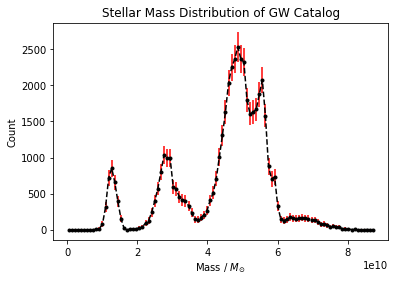

max Dist = 124.07


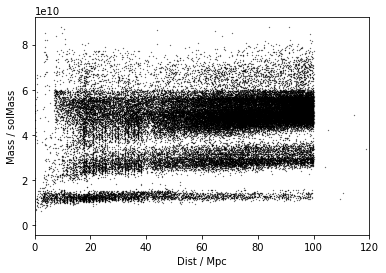

In [3]:
# =============================
# Galaxy Catalog Characteristic
# =============================

# Mass distribution
print('range of Stellar Mass =', 
      format(min(GWGC_with_mass['EST_STELLAR_M']), '.0f'), '-', 
      format(max(GWGC_with_mass['EST_STELLAR_M']), '.0f'))

bins = 100
N, mass = np.histogram(GWGC_with_mass['EST_STELLAR_M'], bins, 
                       range = (0, max(GWGC_with_mass['EST_STELLAR_M'])))
mass_mid = (mass[1:] + mass[:-1]) / 2

plt.errorbar(mass_mid, N, yerr = 4*np.sqrt(N), fmt = 'k.', linestyle = '--', ecolor = 'r')
plt.xlabel('Mass / $M_{\odot}$')
plt.ylabel('Count')
plt.title('Stellar Mass Distribution of GW Catalog')
plt.savefig('Stellar_Mass_Distribution.png')
plt.show()

# Mass vs Dist
print('max Dist =', max(GWGC_with_mass['Dist']))
plt.plot(GWGC_with_mass['Dist'], GWGC_with_mass['EST_STELLAR_M'], 'k.', markersize = 0.5)
plt.xlim(0, 120)
plt.xlabel('Dist / Mpc')
plt.ylabel('Mass / solMass')
plt.show()

In [4]:
# ===========================
# Estimate Galaxy Metallicity
# ===========================

# Estimate Galaxy Metallicity from Tremonti 2004 MZ Relation
Z_log12 = (-1.492 + 1.847*np.log10(GWGC_with_mass['EST_STELLAR_M']) 
          - 0.0826*np.log10(GWGC_with_mass['EST_STELLAR_M'])**2) 

# Converge 12+log(O/H) form to primordial metallicity
Z = 33.8286 * 10**(Z_log12 - 12) 
GWGC_COMPLETE = GWGC_with_mass # Final table for GWGC analysis

# Change galaxy mass to 10_12 solar mass
GWGC_COMPLETE['EST_STELLAR_M'] = np.round(GWGC_with_mass['EST_STELLAR_M'], decimals = 4)
GWGC_COMPLETE['EST_Z'] = np.round(Z, decimals = 4)

# Construct table for further use
# Take useful information from GWGC
GWGC_COMPLETE = GWGC_COMPLETE['PGC', 'Name', 'RAhour', 'DEdeg', 'TT', 
                              'Bmag', 'Dist', 'EST_STELLAR_M','EST_Z']

ascii.write(GWGC_COMPLETE, data_save_path+'GWGC_COMPLETE.csv', 
            format='basic', fast_writer=False)

Range of Metallicity =  0.0052 0.0228


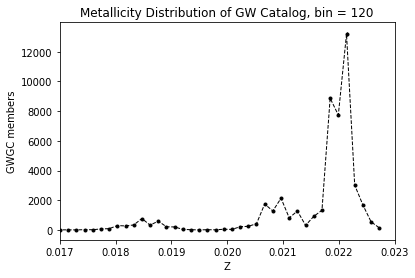

In [5]:
# ========================
# Metallicity Distribution
# ========================
bins = 120
min_Z = min(GWGC_COMPLETE['EST_Z'])
max_Z = max(GWGC_COMPLETE['EST_Z'])

N, Z = np.histogram(GWGC_COMPLETE['EST_Z'], bins, range = (min_Z, max_Z))
Z_mid = (Z[1:] + Z[:-1])/2
plt.errorbar(Z_mid, N, yerr = np.sqrt(N), fmt = 'k.', 
             linestyle = '--', linewidth = 1, ecolor = 'k')
print('Range of Metallicity = ', min_Z, max_Z)

plt.xlim(0.017, 0.023)
plt.xlabel('Z')
plt.ylabel('GWGC members')
plt.title('Metallicity Distribution of GW Catalog, bin = 120')
plt.show()

Members of galaxy groups: 
 49184 Z = 0.0216 std = 0.001 
 1415 Z = 0.0224 std = 0.0002 
 1614 Z = 0.0225 std = 0.0001 
 28963 Z = 0.0221 std = 0.0002 
 5529 Z = 0.0219 std = 0.0002 
 2285 Z = 0.0212 std = 0.0002 
 6145 Z = 0.0208 std = 0.0002 
 3233 Z = 0.0185 std = 0.0004 



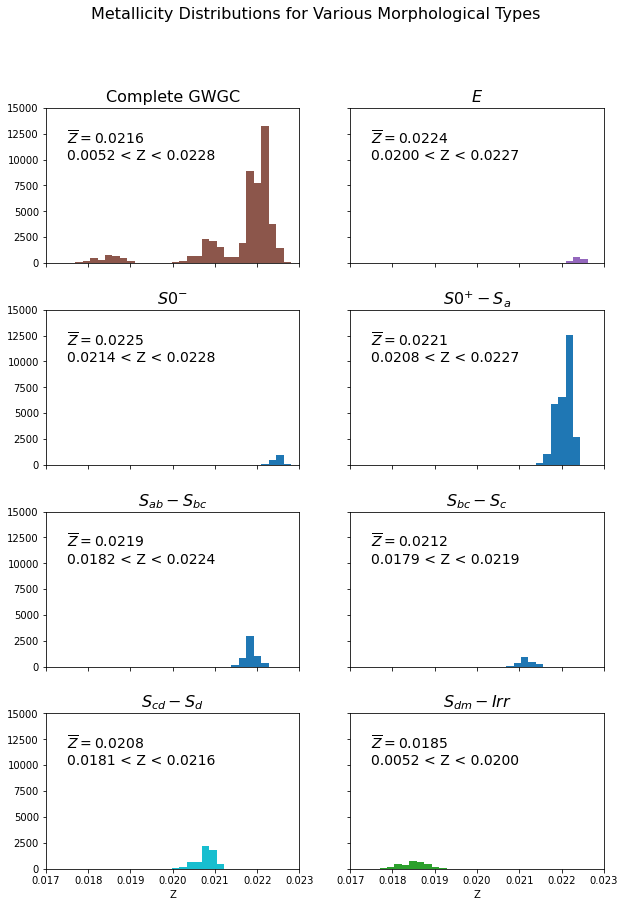

In [6]:
# ================================================
# Metallicity Distribution for 7 types of galaxies
# ================================================

fig, ((ax1, ax2), (ax3, ax4), 
      (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, sharey = False, 
                                             gridspec_kw={'hspace': 0.3, 'wspace': 0.2}, 
                                             figsize = (10, 14))
fig.suptitle('Metallicity Distributions for Various Morphological Types', fontsize = 16)
bins = 100

# Complete distribution of metallicity
ax1.hist(GWGC_COMPLETE['EST_Z'], bins, range = (min_Z, max_Z), color='tab:brown')
ax1.set_title('Complete GWGC', fontsize=16)
ax1.text(0.0175, 11500, r'$\overline{Z} = 0.0216$', fontsize=14)
ax1.text(0.0175, 10000, r'0.0052 < Z < 0.0228', fontsize=14)

# 1st type of galaxy
mask1 = GWGC_COMPLETE['TT'] >= -6
GWGC_Z1 = GWGC_COMPLETE[mask1]
mask1 = GWGC_Z1['TT'] <= -4.01
GWGC_Z1 = GWGC_Z1[mask1]
GWGC_Z1['GROUP'] = 1 # Assign group number
ax2.hist(GWGC_Z1['EST_Z'], bins, range = (min_Z, max_Z), color='tab:purple')
ax2.set_title('$E$', fontsize=16)
ax2.text(0.0175, 11500, r'$\overline{Z} = 0.0224$', fontsize=14)
ax2.text(0.0175, 10000, r'0.0200 < Z < 0.0227', fontsize=14)

# 2nd type of galaxy
mask2 = GWGC_COMPLETE['TT'] >= -4
GWGC_Z2 = GWGC_COMPLETE[mask2]
mask2 = GWGC_Z2['TT'] <= -2.01
GWGC_Z2 = GWGC_Z2[mask2]
GWGC_Z2['GROUP'] = 2 # Assign group number
ax3.hist(GWGC_Z2['EST_Z'], bins, range = (min_Z, max_Z), color='tab:blue')
ax3.set_title('$S0^{-}$', fontsize=16)
ax3.text(0.0175, 11500, r'$\overline{Z} = 0.0225$', fontsize=14)
ax3.text(0.0175, 10000, r'0.0214 < Z < 0.0228', fontsize=14)

# 3rd type of galaxy
mask3 = GWGC_COMPLETE['TT'] >= -2
GWGC_Z3 = GWGC_COMPLETE[mask3]
mask3 = GWGC_Z3['TT'] <= 0.99
GWGC_Z3 = GWGC_Z3[mask3]
GWGC_Z3['GROUP'] = 2 # Assign group number
ax4.hist(GWGC_Z3['EST_Z'], bins, range = (min_Z, max_Z), color='tab:blue')
ax4.set_title('$S0^{+} - S_a$', fontsize=16)
ax4.text(0.0175, 11500, r'$\overline{Z} = 0.0221$', fontsize=14)
ax4.text(0.0175, 10000, r'0.0208 < Z < 0.0227', fontsize=14)

# 4th type of galaxy
mask4 = GWGC_COMPLETE['TT'] >= 1
GWGC_Z4 = GWGC_COMPLETE[mask4]
mask4 = GWGC_Z4['TT'] <= 3.99
GWGC_Z4 = GWGC_Z4[mask4]
GWGC_Z4['GROUP'] = 2 # Assign group number
ax5.hist(GWGC_Z4['EST_Z'], bins, range = (min_Z, max_Z), color='tab:blue')
ax5.set_title('$S_{ab} - S_{bc}$', fontsize=16)
ax5.text(0.0175, 11500, r'$\overline{Z} = 0.0219$', fontsize=14)
ax5.text(0.0175, 10000, r'0.0182 < Z < 0.0224', fontsize=14)

# 5th type of galaxy
mask5 = GWGC_COMPLETE['TT'] >= 4
GWGC_Z5 = GWGC_COMPLETE[mask5]
mask5 = GWGC_Z5['TT'] <= 4.99
GWGC_Z5 = GWGC_Z5[mask5]
GWGC_Z5['GROUP'] = 2 # Assign group number
ax6.hist(GWGC_Z5['EST_Z'], bins, range = (min_Z, max_Z), color='tab:blue')
ax6.set_title('$S_{bc} - S_c$', fontsize=16)
ax6.text(0.0175, 11500, r'$\overline{Z} = 0.0212$', fontsize=14)
ax6.text(0.0175, 10000, r'0.0179 < Z < 0.0219', fontsize=14)

# 6th type of galaxy
mask6 = GWGC_COMPLETE['TT'] >= 5
GWGC_Z6 = GWGC_COMPLETE[mask6]
mask6 = GWGC_Z6['TT'] <= 7.99
GWGC_Z6 = GWGC_Z6[mask6]
GWGC_Z6['GROUP'] = 3 # Assign group number
ax7.hist(GWGC_Z6['EST_Z'], bins, range = (min_Z, max_Z), color='tab:cyan')
ax7.set_title('$S_{cd} - S_d$', fontsize=16)
ax7.text(0.0175, 11500, r'$\overline{Z} = 0.0208$', fontsize=14)
ax7.text(0.0175, 10000, r'0.0181 < Z < 0.0216', fontsize=14)

# 7th type of galaxy
mask7= GWGC_COMPLETE['TT'] >= 8
GWGC_Z7 = GWGC_COMPLETE[mask7]
mask7 = GWGC_Z7['TT'] <= 10
GWGC_Z7 = GWGC_Z7[mask7]
GWGC_Z7['GROUP'] = 4 # Assign group number
ax8.hist(GWGC_Z7['EST_Z'], bins, range = (min_Z, max_Z), color='tab:green')
ax8.set_title('$S_{dm} - Irr$', fontsize=16)
ax8.text(0.0175, 11500, r'$\overline{Z} = 0.0185$', fontsize=14)
ax8.text(0.0175, 10000, r'0.0052 < Z < 0.0200', fontsize=14)

# Plotting styles
ax7.set(xlabel='Z')
ax8.set(xlabel='Z')
for ax in fig.get_axes():
    ax.label_outer()
for ax in fig.get_axes():
    ax.set_xlim(0.017, 0.023)
for ax in fig.get_axes():
    ax.set_ylim(0, 15000)

# Memebers of each type
print('Members of galaxy groups:', '\n',
      len(GWGC_COMPLETE), 'Z =', round(np.mean(GWGC_COMPLETE['EST_Z']), 4), 
      'std =', round(np.std(GWGC_COMPLETE['EST_Z']), 4), '\n',
      len(GWGC_Z1), 'Z =', round(np.mean(GWGC_Z1['EST_Z']), 4), 
      'std =', round(np.std(GWGC_Z1['EST_Z']), 4), '\n',
      len(GWGC_Z2), 'Z =', round(np.mean(GWGC_Z2['EST_Z']), 4), 
      'std =', round(np.std(GWGC_Z2['EST_Z']), 4), '\n',
      len(GWGC_Z3), 'Z =', round(np.mean(GWGC_Z3['EST_Z']), 4), 
      'std =', round(np.std(GWGC_Z3['EST_Z']), 4), '\n',
      len(GWGC_Z4), 'Z =', round(np.mean(GWGC_Z4['EST_Z']), 4), 
      'std =', round(np.std(GWGC_Z4['EST_Z']), 4), '\n',
      len(GWGC_Z5), 'Z =', round(np.mean(GWGC_Z5['EST_Z']), 4), 
      'std =', round(np.std(GWGC_Z5['EST_Z']), 4), '\n',
      len(GWGC_Z6), 'Z =', round(np.mean(GWGC_Z6['EST_Z']), 4), 
      'std =', round(np.std(GWGC_Z6['EST_Z']), 4), '\n',
      len(GWGC_Z7), 'Z =', round(np.mean(GWGC_Z7['EST_Z']), 4), 
      'std =', round(np.std(GWGC_Z7['EST_Z']), 4), '\n',)

#plt.savefig('Metallicity_Distribution_Full.png')
plt.show()

In [55]:
# =================================
# Galaxy Metallicity categorization
# =================================

# Metallicity Z for each catagory
print('Metallicity for each catalog:', '\n')

# Group 1 Elliptical galaxy
print(np.mean(GWGC_Z1['EST_Z']))

# Group 2 Spiral galaxy
print(np.mean(np.concatenate((GWGC_Z2['EST_Z'], GWGC_Z3['EST_Z'], 
                              GWGC_Z4['EST_Z'], GWGC_Z5['EST_Z']))))

# Group 3 S_cd - S_d
print(np.mean(GWGC_Z6['EST_Z']))

# Group 4 Irragular galaxy
print(np.mean(GWGC_Z7['EST_Z']))


# Generate table for DATA_ANALISYS
GWGC_COMPLETE_Categorized = vstack([GWGC_Z1, GWGC_Z2, GWGC_Z3, GWGC_Z4, 
                                    GWGC_Z5, GWGC_Z6, GWGC_Z7])

# Converge table into Pandas DataFrame
# Painful, but nessesary for the consistency with COSMIC data
import pandas as pd

GWGC_pd = GWGC_COMPLETE_Categorized.to_pandas()
GWGC_pd.to_csv(data_save_path+'GWGC_COMPLETE_Categorized.csv')
GWGC_pd

Metallicity for each catalog: 

0.022357243816254417
0.021990359719725978
0.02076211554109032
0.01847813176616146


,PGC,Name,RAhour,DEdeg,TT,Bmag,Dist,EST_STELLAR_M,EST_Z,GROUP
0,595,b'NGC0005 ',0.13025,35.3623,-4.9,14.39,72.14,6.096786e+10,0.0224,1
1,708,b'PGC000708 ',0.16857,-36.7751,-5.0,14.69,95.35,6.223891e+10,0.0224,1
2,1037,b'NGC0057 ',0.25857,17.3284,-4.9,12.28,77.85,5.202817e+10,0.0221,1
3,1185,b'PGC001185 ',0.30411,30.0632,-5.0,15.79,93.94,6.689941e+10,0.0225,1
4,1206,b'PGC001206 ',0.31003,-6.3013,-5.0,14.89,89.99,6.308628e+10,0.0224,1
...,...,...,...,...,...,...,...,...,...,...
49179,4215191,b'SDSSJ095100.45+200420.9 ',9.85013,20.0725,9.0,17.55,49.44,1.487124e+10,0.0190,4
49180,4231240,b'SDSSJ101726.52+292210.6 ',10.29070,29.3696,8.0,16.23,7.96,1.375272e+10,0.0187,4
49181,4541250,b'SDSSJ150349.93+005831.7 ',15.06386,0.9765,10.0,16.35,28.90,1.385441e+10,0.0188,4
49182,4581793,b'PGC4581793 ',11.61493,17.8904,8.0,18.02,47.75,1.526951e+10,0.0191,4


Part 2: Gravitational Wave Power Spectrum
==

In [1]:
from cosmic import MC_samp
import numpy as np
import pandas as pd
import GW_calcs
import MW_maker
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import colors
# Constants
Rsun_au = 1/215.032
day_yr = 1/365.25
yr_sec = 3.155e7
G = 6.67e-11
c = 2.998e+8
Msun = 1.989e30
parsec = 3.086e+19

Tobs = 8
SNR_lim = 7

# Data path and date file
data_path = './DATA/'
data_save_path = './generated_data/'

In [2]:
# ================================
# Read the COSMIC fixed population
# ================================

file_name_1 = 'dat_kstar1_10_13_kstar2_10_13_SFstart_10000_SFduration_0_metallicity_0.0223.h5'
file_name_2 = 'dat_kstar1_10_13_kstar2_10_13_SFstart_11000_SFduration_0_metallicity_0.0185.h5'
file_name_3 = 'dat_kstar1_10_13_kstar2_10_13_SFstart_11000_SFduration_0_metallicity_0.0208.h5'
file_name_4 = 'dat_kstar1_10_13_kstar2_10_13_SFstart_11000_SFduration_0_metallicity_0.022.h5'

# Read in pandas DataFrame
conv_1 = pd.read_hdf(data_path + file_name_1, key='conv')
conv_2 = pd.read_hdf(data_path + file_name_2, key='conv')
conv_3 = pd.read_hdf(data_path + file_name_3, key='conv')
conv_4 = pd.read_hdf(data_path + file_name_4, key='conv')

print('', 'conv pop num 1:', len(conv_1), '\n',
          'conv pop num 2:', len(conv_2), '\n',
          'conv pop num 3:', len(conv_3), '\n',
          'conv pop num 4:', len(conv_4), '\n')

# ==============================================================
# Compute total mass of fixed pop
m_sim_1 = pd.read_hdf(data_path + file_name_1, key='mass_stars')
m_sim_tot_1 = m_sim_1.max()[0]
m_sim_2 = pd.read_hdf(data_path + file_name_2, key='mass_stars')
m_sim_tot_2 = m_sim_2.max()[0]
m_sim_3 = pd.read_hdf(data_path + file_name_3, key='mass_stars')
m_sim_tot_3 = m_sim_3.max()[0]
m_sim_4 = pd.read_hdf(data_path + file_name_4, key='mass_stars')
m_sim_tot_4 = m_sim_4.max()[0]

# Set the base-model astrophysical mass
# Assume it to be 1e10 solar mass, scale back later
m_astro = 1e10   # <=== Baseline astrophysical mass
base_dist = 1000 # <=== Baseline astrophysical distance

# Find galaxy astrophysical stellar pop
n_astro_1 = int(len(conv_1) * m_astro / m_sim_tot_1)
n_astro_2 = int(len(conv_2) * m_astro / m_sim_tot_2)
n_astro_3 = int(len(conv_3) * m_astro / m_sim_tot_3)
n_astro_4 = int(len(conv_4) * m_astro / m_sim_tot_4)

print('', 'astro pop num 1:', n_astro_1, '\n',
          'astro pop num 2:', n_astro_2, '\n',
          'astro pop num 3:', n_astro_3, '\n',
          'astro pop num 4:', n_astro_4)

 conv pop num 1: 215722 
 conv pop num 2: 214174 
 conv pop num 3: 203287 
 conv pop num 4: 207601 

 astro pop num 1: 124665109 
 astro pop num 2: 135909144 
 astro pop num 3: 133022331 
 astro pop num 4: 131738093


In [3]:
# ===================================
# Generating galaxy binary population
# ===================================

# Data path and date file
data_path = './DATA/'
data_save_path = './generated_data/'

# Set the base-model astrophysical mass
# Assume it to be 1e10 solar mass, 1000 Mpc, 
# scale back later
m_astro = 1e10
base_dist = 1000
model = 'ThinDisk'

print('', 'pop 1:', '\n', 
          'Conv pop num:', len(conv_1), '\n', 
          'Conv pop mass:', m_sim_tot_1, '\n',
          'Astro pop num:', n_astro_1)
print('', 'pop 2:', '\n', 
          'Conv pop num:', len(conv_2), '\n', 
          'Conv pop mass:', m_sim_tot_2, '\n',
          'Astro pop num:', n_astro_2)
print('', 'pop 3:', '\n', 
          'Conv pop num:', len(conv_3), '\n', 
          'Conv pop mass:', m_sim_tot_3, '\n',
          'Astro pop num:', n_astro_3)
print('', 'pop 4:', '\n', 
          'Conv pop num:', len(conv_4), '\n', 
          'Conv pop mass:', m_sim_tot_4, '\n',
          'Astro pop num:', n_astro_4)

# =================================
# Generate galaxy binary population
# (This may take a while, ~20 min)
# (Run with memory > 50G)
# =================================

glx_pop_file_name_1 = 'glx_pop_1.h5'
glx_pop_file_name_2 = 'glx_pop_2.h5'
glx_pop_file_name_3 = 'glx_pop_3.h5'
glx_pop_file_name_4 = 'glx_pop_4.h5'

print('Begin generating galaxy pops.', '\n')

# =========================================================
print('Generating galaxy pop 1...')
glx_pop = MW_maker.LISA_Galaxy(conv=conv_1, 
                               model=model, 
                               m_sim_tot=m_sim_tot_1, 
                               kstars='all stars')
glx_pop.to_hdf(data_save_path + glx_pop_file_name_1, key='conv')
print('Galaxy pop 1 data done.')

# =========================================================
print('Generating galaxy pop 2...')
glx_pop = MW_maker.LISA_Galaxy(conv=conv_2, 
                               model=model, 
                               m_sim_tot=m_sim_tot_2, 
                               kstars='all stars')
glx_pop.to_hdf(data_save_path + glx_pop_file_name_2, key='conv')
print('Galaxy pop 2 data done.')

# =========================================================
print('Generating galaxy pop 3...')
glx_pop = MW_maker.LISA_Galaxy(conv=conv_3, 
                               model=model, 
                               m_sim_tot=m_sim_tot_3, 
                               kstars='all stars')
glx_pop.to_hdf(data_save_path + glx_pop_file_name_3, key='conv')
print('Galaxy pop 3 data done.')

# =========================================================
print('Generating galaxy pop 4...')
glx_pop = MW_maker.LISA_Galaxy(conv=conv_4, 
                               model=model, 
                               m_sim_tot=m_sim_tot_4, 
                               kstars='all stars')
glx_pop.to_hdf(data_save_path + glx_pop_file_name_4, key='conv')
print('Galaxy pop 4 data done.', '\n')

print('Galaxy populaitons all done!')

 pop 1: 
 Conv pop num: 215722 
 Conv pop mass: 17304119.90700576 
 Astro pop num: 124665109
 pop 2: 
 Conv pop num: 214174 
 Conv pop mass: 15758615.813292218 
 Astro pop num: 135909144
 pop 3: 
 Conv pop num: 203287 
 Conv pop mass: 15282170.85702444 
 Astro pop num: 133022331
 pop 4: 
 Conv pop num: 207601 
 Conv pop mass: 15758615.813292217 
 Astro pop num: 131738093

 Base-model astrophysical binaries mass: 10000000000.0

Begin generating galaxy pops. 

Generating galaxy pop 1...
The number of binaries in the population is: 538553272
filtered numbers 115109327


/projects/b1094/wyy6563/Extragalactic_confusion_foreground/GW_calcs.py:312: RuntimeWarning: invalid value encountered in double_scalars
  a_evol = c_0*e_evol**(12./19)/(1-e_evol**2)*(1+(121./304)*e_evol**2)**(870./2299)
/projects/b1094/wyy6563/Extragalactic_confusion_foreground/GW_calcs.py:315: RuntimeWarning: invalid value encountered in double_scalars
  c_0 = a_0*(1-e_0**2)*e_0**(-12./19)*(1+(121./304)*e_0**2)**(-870./2299)
/projects/b1094/wyy6563/Extragalactic_confusion_foreground/GW_calcs.py:251: RuntimeWarning: invalid value encountered in double_scalars
  c_0 = a_0*(1-e_0**2)*e_0**(-12./19)*(1+(121./304)*e_0**2)**(-870./2299)
/projects/b1094/wyy6563/Extragalactic_confusion_foreground/GW_calcs.py:257: RuntimeWarning: invalid value encountered in double_scalars
  nominator = e_0**(-29./19)*(1-e_0**2)**(3./2)


Galaxy pop 1 data done.
Generating galaxy pop 2...
The number of binaries in the population is: 587127505
filtered numbers 121096727
Galaxy pop 2 data done.
Generating galaxy pop 3...
The number of binaries in the population is: 574656472
filtered numbers 119549193
Galaxy pop 3 data done.
Generating galaxy pop 4...
The number of binaries in the population is: 569108562
filtered numbers 119334034
Galaxy pop 4 data done. 

Galaxy populaitons all done!


In [3]:
# =====================
# Compute GW LISA Power
# (~10 min)
# =====================
data_path = './generated_data/'

'''
Compute the base-model LISA power
Where:
Luminosity distance = 1000 kpc
Galaxy stellar mass = 1e10 solar mass

Notice:
Units in COSMIC differenct than GWGC
COSMIC[kpc] - GWGC[Mpc]
'''

# Load galaxy date files
glx_pop_1 = pd.read_hdf(data_path + 'glx_pop_1.h5', key='conv')
glx_pop_2 = pd.read_hdf(data_path + 'glx_pop_2.h5', key='conv')
glx_pop_3 = pd.read_hdf(data_path + 'glx_pop_3.h5', key='conv')
glx_pop_4 = pd.read_hdf(data_path + 'glx_pop_4.h5', key='conv')
print('Galaxy data file loaded.', '\n')

# Scale the simulation power to astrophysical parameter
model = 'ThinDisk'
n_pop_1 = MC_samp.mass_weighted_number(component_mass=MC_samp.select_component_mass(model),
                                         dat=conv_1,
                                         total_sampled_mass=m_sim_tot_1)
n_pop_2 = MC_samp.mass_weighted_number(component_mass=MC_samp.select_component_mass(model),
                                         dat=conv_2,
                                         total_sampled_mass=m_sim_tot_2)
n_pop_3 = MC_samp.mass_weighted_number(component_mass=MC_samp.select_component_mass(model),
                                         dat=conv_3,
                                         total_sampled_mass=m_sim_tot_3)
n_pop_4 = MC_samp.mass_weighted_number(component_mass=MC_samp.select_component_mass(model),
                                         dat=conv_4,
                                         total_sampled_mass=m_sim_tot_4)

# astrophysical to simulation binary number ratio
m_ratio_1 = n_astro_1/n_pop_1
m_ratio_2 = n_astro_2/n_pop_2
m_ratio_3 = n_astro_3/n_pop_3
m_ratio_4 = n_astro_4/n_pop_4

print('', 'Astro to Sim m ratio 1:', round(m_ratio_1, 12), '\n',
          'Astro to Sim m ratio 2:', round(m_ratio_2, 12), '\n',
          'Astro to Sim m ratio 3:', round(m_ratio_3, 12), '\n',
          'Astro to Sim m ratio 4:', round(m_ratio_4, 12), '\n')


# Compute LISA Power
# (Take ~ 5min, take another break)
# Power file names
power_file_name_1 = 'glx_power_1.h5'
power_file_name_2 = 'glx_power_2.h5'
power_file_name_3 = 'glx_power_3.h5'
power_file_name_4 = 'glx_power_4.h5'
print('Begin computing LISA GW power.', '\n')

# =========================================================
print('Computing galaxy GW power 1...')
glx_pop = glx_pop_1
m_ratio = m_ratio_1
power_file_name = power_file_name_1
glx_pop.dist = glx_pop.dist*0 + base_dist
LISA_power = GW_calcs.LISA_power(glx_pop, Tobs)
LISA_power.strain_2 = LISA_power.strain_2 * m_ratio
LISA_power.to_hdf(data_path + power_file_name, key='power')
print('Galaxy GW power 1 done.')
# =========================================================
print('Computing galaxy GW power 2...')
glx_pop = glx_pop_2
m_ratio = m_ratio_2
power_file_name = power_file_name_2
glx_pop.dist = glx_pop.dist*0 + base_dist
LISA_power = GW_calcs.LISA_power(glx_pop, Tobs)
LISA_power.strain_2 = LISA_power.strain_2 * m_ratio
LISA_power.to_hdf(data_path + power_file_name, key='power')
print('Galaxy GW power 2 done.')
# =========================================================
print('Computing galaxy GW power 3...')
glx_pop = glx_pop_3
m_ratio = m_ratio_3
power_file_name = power_file_name_3
glx_pop.dist = glx_pop.dist*0 + base_dist
LISA_power = GW_calcs.LISA_power(glx_pop, Tobs)
LISA_power.strain_2 = LISA_power.strain_2 * m_ratio
LISA_power.to_hdf(data_path + power_file_name, key='power')
print('Galaxy GW power 3 done.')
# =========================================================
print('Computing galaxy GW power 4...')
glx_pop = glx_pop_4
m_ratio = m_ratio_4
power_file_name = power_file_name_4
glx_pop.dist = glx_pop.dist*0 + base_dist
LISA_power = GW_calcs.LISA_power(glx_pop, Tobs)
LISA_power.strain_2 = LISA_power.strain_2 * m_ratio
LISA_power.to_hdf(data_path + power_file_name, key='power')
print('Galaxy GW power 4 done.', '\n')

print('Galaxy GW powers all done!')

Galaxy data file loaded. 

 Astro to Sim m ratio 1: 0.231481481 
 Astro to Sim m ratio 2: 0.23148148033 
 Astro to Sim m ratio 3: 0.231481480644 
 Astro to Sim m ratio 4: 0.231481481384 

Begin computing LISA GW power. 

Computing galaxy GW power 1...


/projects/b1094/wyy6563/Extragalactic_confusion_foreground/GW_calcs.py:585: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d=np.array(dat_circ.dist))**2
/projects/b1094/wyy6563/Extragalactic_confusion_foreground/GW_calcs.py:587: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_circ['digits'] = np.digitize(dat_circ.f_gw_peak, LISA_freq)


Galaxy GW power 1 done.
Computing galaxy GW power 2...
Galaxy GW power 2 done.
Computing galaxy GW power 3...
Galaxy GW power 3 done.
Computing galaxy GW power 4...
Galaxy GW power 4 done. 

Galaxy GW powers all done!


Number of base-line model population: 385817 1531893 426128 450353
Data imported. 



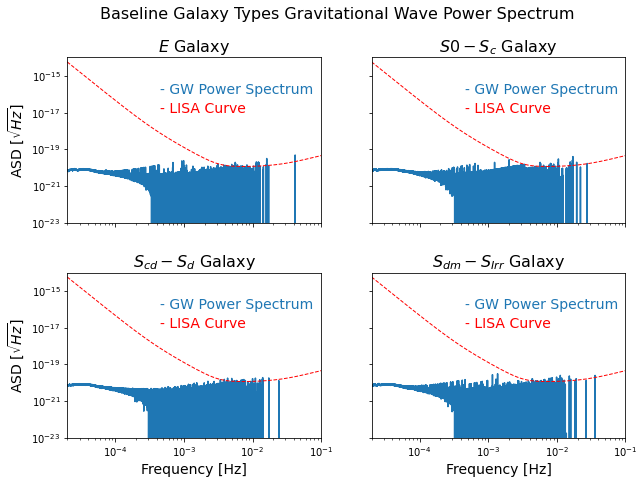

Group Power Spectrum Figure Saved.


<Figure size 432x288 with 0 Axes>

In [27]:
# ==========================================================
# Plot the total gravitational wave power of galaxy binaries
# against the LISA curve
# ==========================================================
from cosmic import MC_samp
import numpy as np
import pandas as pd
import GW_calcs
import MW_maker
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import colors
# Constants
Rsun_au = 1/215.032
day_yr = 1/365.25
yr_sec = 3.155e7
G = 6.67e-11
c = 2.998e+8
Msun = 1.989e30
parsec = 3.086e+19

Tobs = 8
SNR_lim = 7

data_path = './generated_data/'

# Import Data
LISA_PSD = GW_calcs.lisa_PSD()
LISA_power_1 = pd.read_hdf(data_path + 'glx_power_1.h5', key='power')
LISA_power_2 = pd.read_hdf(data_path + 'glx_power_2.h5', key='power')
LISA_power_3 = pd.read_hdf(data_path + 'glx_power_3.h5', key='power')
LISA_power_4 = pd.read_hdf(data_path + 'glx_power_4.h5', key='power')

LISA_power_1 = LISA_power_1[LISA_power_1['strain_2'] != 0]
LISA_power_2 = LISA_power_2[LISA_power_2['strain_2'] != 0]
LISA_power_3 = LISA_power_3[LISA_power_3['strain_2'] != 0]
LISA_power_4 = LISA_power_4[LISA_power_4['strain_2'] != 0]

print('Number of base-line model population:', 
      len(LISA_power_1), len(LISA_power_2), len(LISA_power_3), len(LISA_power_4))
print('Data imported.', '\n')

# Figure Parameters
fs = 14 # fontsize
fig, ((ax1, ax2), 
      (ax3, ax4)) = plt.subplots(2, 2, sharey = False, 
                                 gridspec_kw={'hspace': 0.3, 'wspace': 0.2}, figsize = (10, 7))
fig.suptitle('Baseline Galaxy Types Gravitational Wave Power Spectrum', fontsize = fs+2)

# Plotting Style
baselines = [LISA_power_1, LISA_power_2, LISA_power_3, LISA_power_4]
glx_names = ['$E$', '$S0 - S_c$', '$S_{cd} - S_d$','$S_{dm} - S_{Irr}$']
axs = [ax1, ax2, ax3, ax4]
text_x = 4.5e-4 # text location
text_y_up = 1e-16 # text location
text_y_dn = 1e-17 # text location
fs = 14 # fontsize
ax3.set_xlabel('Frequency [Hz]', fontsize=fs)
ax4.set_xlabel('Frequency [Hz]', fontsize=fs)
ax1.set_ylabel('ASD [$\sqrt{Hz}$]', fontsize=fs)
ax3.set_ylabel('ASD [$\sqrt{Hz}$]', fontsize=fs)

# Plot the Grid
for i in range(4):
    axs[i].plot(baselines[i].f_gw, 
               (baselines[i].strain_2*Tobs*yr_sec)**0.5, color='tab:blue', rasterized=True)
    axs[i].plot(np.linspace(5e-6, 0.1, 10000), 
               (LISA_PSD(np.linspace(5e-6, 0.1, 10000)))**0.5, lw=1, linestyle='--', color='red')
    axs[i].set_title(glx_names[i]+' Galaxy', fontsize=fs+2)
    axs[i].text(text_x, text_y_up, 
                r'- '+'GW Power Spectrum', color = 'tab:blue', fontsize=fs)
    axs[i].text(text_x, text_y_dn, 
                r'- LISA Curve', color = 'red', fontsize=fs)

for ax in fig.get_axes():
    ax.label_outer()
    ax.set_xlim(2e-5, 1e-1)
    ax.set_ylim(1e-23, 1e-14)
    ax.set_xscale('log')
    ax.set_yscale('log')

plt.show()
save_plot_name = 'Baseline_GW_power_spec'
plt.savefig('figures/' + save_plot_name + '.png')
print('Group Power Spectrum Figure Saved.')

Part 3: Extragalactic GW Power Spectrum
==

In [10]:
from cosmic import MC_samp
import numpy as np
import pandas as pd
import GW_calcs
import MW_maker
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from IPython.display import clear_output

# Constants
Rsun_au = 1/215.032
day_yr = 1/365.25
yr_sec = 3.155e7
G = 6.67e-11
c = 2.998e+8
Msun = 1.989e30
parsec = 3.086e+19

data_path = './generated_data/'
data_save_path = './generated_data/'
Tobs = 8
SNR_lim = 7

In [56]:
# ============================================
# Import GWGC & Calculated LISA Power Spectrum
# ============================================

# Import GWGC cataglorized table
GWGC_original = pd.read_csv(data_path + 'GWGC_COMPLETE_Categorized.csv')
GWGC_original = GWGC_original.drop(['Unnamed: 0'], axis=1)

# Exclude Globular Clusters
GWGC = GWGC_original.loc[GWGC_original.Dist>4]
GWGC = GWGC.append(GWGC_original[32160:32161]) #Add back M31
print('Exclude Globular Clusters:', len(GWGC_original)-len(GWGC))
#print(GWGC)

print('=====================================================',)

# =========================================================
# Compute the total gravitational radiation power for Group
# =========================================================

# Galaxy categorization
'''
Have base-model the LISA Gravitational radiation power spectrum:
1. Luminosity distance = 1000 kpc = 1 Mpc, notice GWGC unit in Mpc
2. Galaxy stellar mass = 1e10 solar mass
'''

# Group GWGC following the categorization method
# (Save an additinoal loop)
GWGC_G1 = GWGC.loc[GWGC.GROUP == 1]
GWGC_G2 = GWGC.loc[GWGC.GROUP == 2]
GWGC_G3 = GWGC.loc[GWGC.GROUP == 3]
GWGC_G4 = GWGC.loc[GWGC.GROUP == 4]

# Reset index of GWGC group tables
# Important! Otherwise for-loop won't run
GWGC_G1 = GWGC_G1.reset_index()
GWGC_G2 = GWGC_G2.reset_index()
GWGC_G3 = GWGC_G3.reset_index()
GWGC_G4 = GWGC_G4.reset_index()

print('Number of members in the group:',
      len(GWGC_G1), len(GWGC_G2), len(GWGC_G3), len(GWGC_G4))

Exclude Globular Clusters: 163
Number of members in the group: 1383 38376 6130 3132


Sample data of Gravitational Wave Galaxy Catalog(GWGC) by White et al. 2010

GWGC Parameters:
1. PGC: Identifier from HYPERLEDA
2. Name: Common Galaxy Name
3. RA: Right ascension [hour]
4. DEC: Declination [degree]
5. TT: Galaxy Morphological Type [Hubble Sequence]
6. Bmag: Blue magnitude
7. Dist: Luminosity Distance [Mpc]

Computed data:
8. EST_STELLAR_M: Estimated galaxy stellar mass[$M_{odot}]
9. EST_Z: Estimated galaxy metallicity
10. Categorization label

In [61]:
# ==============================
# Galaxy group power computation
# ==============================
save_data_path = './generated_data/'

# Import Initial Four Baseline Galaxy Power Data
power_file_i_1 = pd.read_hdf(data_path + 'glx_power_1.h5', key='power')
power_file_i_2 = pd.read_hdf(data_path + 'glx_power_2.h5', key='power')
power_file_i_3 = pd.read_hdf(data_path + 'glx_power_3.h5', key='power')
power_file_i_4 = pd.read_hdf(data_path + 'glx_power_4.h5', key='power')

power_file_i_1 = power_file_i_1[power_file_i_1['strain_2'] != 0]
power_file_i_2 = power_file_i_2[power_file_i_2['strain_2'] != 0]
power_file_i_3 = power_file_i_3[power_file_i_3['strain_2'] != 0]
power_file_i_4 = power_file_i_4[power_file_i_4['strain_2'] != 0]

power_file_i = [power_file_i_1, power_file_i_2, power_file_i_3, power_file_i_4]

# Call Galaxy Catalog
group_glx_file = [GWGC_G1, GWGC_G2, GWGC_G3, GWGC_G4]

print('Power and GWGC data loaded.', '\n')
print('Binaries in the initial population:',
      len(power_file_i_1), len(power_file_i_2), 
      len(power_file_i_3), len(power_file_i_4),)

# Set saving path
save_file_names = ['group1_power_tot', 'group2_power_tot', 
                   'group3_power_tot', 'group4_power_tot']
print('\n', '=============================================', '\n')


# =======================
# Generating Group power
# This might take a while 
# =======================

print('Begin computing group power.',
      'This might take a while. (~10 min)', '\n')

j = 0
while j <= 3:
    
    d_power = power_file_i[j]
    d_group = group_glx_file[j]
    save_file_name = save_file_names[j]
    print('Computing accumulated power for group', j+1, '...', '\n',
          'Galaxy memebers:', len(d_group))
    
    # Scale to stellar mass and distanec
    scale_rate = d_group['EST_STELLAR_M']/1e10 / (d_group['Dist'])**2

    # Set an empty total power table
    g_power_tot = d_power*0
    g_power_tot['f_gw'] = d_power['f_gw']

    # ===========================
    # === Compute Group Power ===
    # ===========================
    i = 0
    for i in range(len(d_group)):
    
        g_power_tot['strain_2'] = g_power_tot['strain_2'] + d_power['strain_2']*scale_rate[i]
        #print('Complete:', i, end='\r') # print progress

    print('Maximum Scale Rate', format((max(scale_rate)), '.4f'))

    g_power_tot.to_hdf(save_data_path + save_file_name + '.h5', key='power')
    print('Group', j+1, 'done.',
          'File saved as:', save_file_name, '\n')
    
    j = j+1

print('All group power computation done!')

Power and GWGC data loaded. 

Binaries in the initial population: 385817 1531893 426128 450353


Begin computing group power. This might take a while. (~10 min) 

Computing accumulated power for group 1 ... 
 Galaxy memebers: 1383
Maximum Scale Rate 0.4517
Group 1 done. File saved as: group1_power_tot 

Computing accumulated power for group 2 ... 
 Galaxy memebers: 38376
Maximum Scale Rate 1.8481
Group 2 done. File saved as: group2_power_tot 

Computing accumulated power for group 3 ... 
 Galaxy memebers: 6130
Maximum Scale Rate 0.1636
Group 3 done. File saved as: group3_power_tot 

Computing accumulated power for group 4 ... 
 Galaxy memebers: 3132
Maximum Scale Rate 0.0844
Group 4 done. File saved as: group4_power_tot 

All group power computation done!


Data imported. 



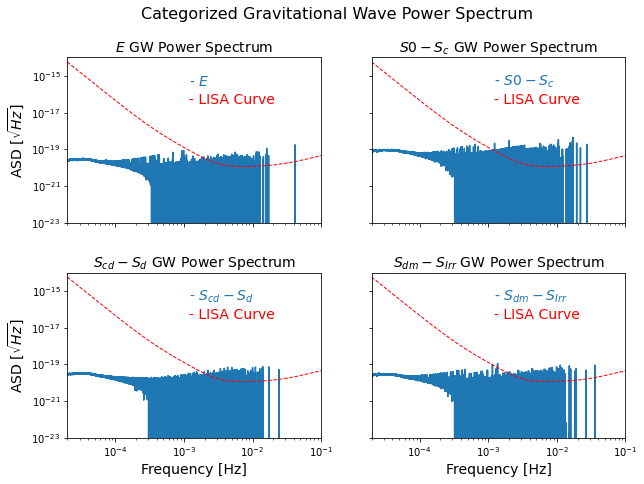

Group Power Spectrum Figure Saved.
Computing Full Power Spectrum...
Group binaries: 385817 1531893 426128 450353 
 Total binaries: 25239975
File saved as: full_power_tot.h5


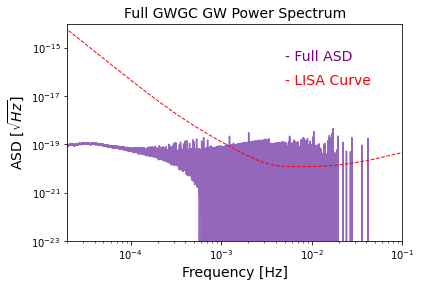

Unrandomized Full Power Spectrum Figure Saved


<Figure size 432x288 with 0 Axes>

In [64]:
# =====================================
# Plotting Un-randomized Power Spectrum
# (Group and total)
# =====================================

# Import Data
LISA_PSD = GW_calcs.lisa_PSD()
g1_power_tot = pd.read_hdf(data_path + 'group1_power_tot.h5', key='power')
g2_power_tot = pd.read_hdf(data_path + 'group2_power_tot.h5', key='power')
g3_power_tot = pd.read_hdf(data_path + 'group3_power_tot.h5', key='power')
g4_power_tot = pd.read_hdf(data_path + 'group4_power_tot.h5', key='power')
print('Data imported.', '\n')

# Figure Parameters
fs = 14 # fontsize
fig, ((ax1, ax2), 
      (ax3, ax4)) = plt.subplots(2, 2, sharey = False, 
                                 gridspec_kw={'hspace': 0.3, 'wspace': 0.2}, figsize = (10, 7))
fig.suptitle('Categorized Gravitational Wave Power Spectrum', fontsize = fs+2)

# Plotting Style
g_powers = [g1_power_tot, g2_power_tot, g3_power_tot, g4_power_tot]
glx_names = ['$E$', '$S0 - S_c$', '$S_{cd} - S_d$','$S_{dm} - S_{Irr}$']
axs = [ax1, ax2, ax3, ax4]
text_x = 1.2e-3 # text location
text_y_up = 3e-16 # text location
text_y_dn = 3e-17 # text location
fs = 14 # fontsize
ax3.set_xlabel('Frequency [Hz]', fontsize=fs)
ax4.set_xlabel('Frequency [Hz]', fontsize=fs)
ax1.set_ylabel('ASD [$\sqrt{Hz}$]', fontsize=fs)
ax3.set_ylabel('ASD [$\sqrt{Hz}$]', fontsize=fs)

# Plot the Grid
for i in range(4):
    axs[i].plot(g_powers[i].f_gw, 
               (g_powers[i].strain_2*Tobs*yr_sec)**0.5, color='tab:blue', rasterized=True)
    axs[i].plot(np.linspace(5e-6, 0.1, 10000), 
               (LISA_PSD(np.linspace(5e-6, 0.1, 10000)))**0.5, lw=1, linestyle='--', color='red')
    axs[i].set_title(glx_names[i]+' GW Power Spectrum', fontsize=fs)
    axs[i].text(text_x, text_y_up, 
                r'- '+glx_names[i], color = 'tab:blue', fontsize=fs)
    axs[i].text(text_x, text_y_dn, 
                r'- LISA Curve', color = 'red', fontsize=fs)

for ax in fig.get_axes():
    ax.label_outer()
    ax.set_xlim(2e-5, 1e-1)
    ax.set_ylim(1e-23, 1e-14)
    ax.set_xscale('log')
    ax.set_yscale('log')

plt.show()
save_plot_name = 'Group_GW_power_spec'
plt.savefig('figures/' + save_plot_name + '.png')
print('Group Power Spectrum Figure Saved.')


# ======================
# Comoputing Total Power
# ======================
print('Computing Full Power Spectrum...')

# Combine all group spectrum
full_power_tot = pd.concat(g_powers)
full_power_tot.sort_values(by=['f_gw'])

LISA_freq = np.arange(1e-7, 1e-1, 1/(Tobs*yr_sec))
full_power_tot['digits'] = np.digitize(full_power_tot.f_gw, LISA_freq)
power = full_power_tot.groupby('digits').sum()['strain_2']
power_tot = np.zeros(len(LISA_freq))
power_tot[np.array(power.index.astype(int))-1] = power
full_power_tot = pd.DataFrame(np.vstack([LISA_freq, power_tot]).T, 
                              columns=['f_gw', 'strain_2'])

print('Group binaries:',
      len(g1_power_tot), len(g2_power_tot), len(g3_power_tot), len(g4_power_tot), '\n',
      'Total binaries:',
      len(full_power_tot))

# Save Data
save_data_path = './DATA/'
full_power_tot.to_hdf(save_data_path + 'full_power_tot' + '.h5', key='power')
print('File saved as:', 'full_power_tot.h5')

# Plotting Total Power
plt.plot(full_power_tot.f_gw, 
        (full_power_tot.strain_2*Tobs*yr_sec)**0.5, color='tab:purple', rasterized=True)
plt.plot(np.linspace(5e-6, 0.1, 10000), 
            (LISA_PSD(np.linspace(5e-6, 0.1, 10000)))**0.5, lw=1, linestyle='--', color='red')

# Plotting Styles
plt.xscale('log')
plt.yscale('log')
plt.xlim(2e-5, 1e-1)
plt.ylim(1e-23, 1e-14)
plt.xlabel('Frequency [Hz]', fontsize=fs)
plt.ylabel('ASD [$\sqrt{Hz}$]', fontsize=fs)

plt.text(0.5e-2, 3e-16, 
         r'- Full ASD', color = 'purple',
         fontsize=fs)
plt.text(0.5e-2, 3e-17, 
         r'- LISA Curve', color = 'red',
         fontsize=fs)
plt.title('Full GWGC GW Power Spectrum',
         fontsize=fs)

plt.show()
save_plot_name = 'Full_GW_power_spec_urand'
plt.savefig('figures/' + save_plot_name + '.png')
print('Unrandomized Full Power Spectrum Figure Saved')

In [64]:
# ===============================================
# Frequency shift & Birth time shift Relationship
# ===============================================

# Randomized frequency distribution
def f_shift(h, f_gw, t_shift, D):
    f_bin = 1/(Tobs*yr_sec)
    C = (5/1024 * G**(25/9) * c**(20/3) * np.pi**(16/3))
    return (((f_gw**(-8/3) - t_shift/(C*h*D))**(-3/8) - 
             f_gw)/f_bin).astype(int, errors='ignore') * f_bin

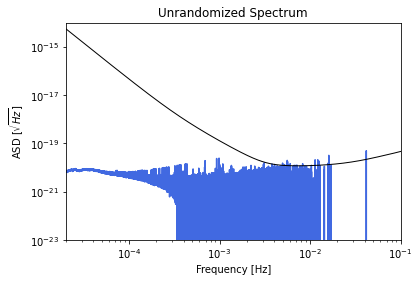

t_shift = 6.314886222457916 yr
LISA resolution = 3.961965134706815e-09
Max f shift = 0.09963008094974778


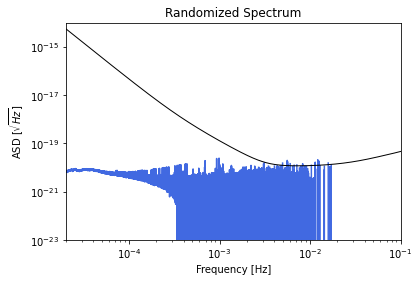

In [65]:
'''
Testing randomization process
for a single galaxy
'''

# ==============================================
# Power spectrum for base-model fixed population
# Check with galaxy power spectrum below
# ==============================================

# Import Gravitational Wave power spectrum data
power_file = 'glx_power_1.h5'
LISA_power = pd.read_hdf(data_path + power_file, key='power')
LISA_power = LISA_power[LISA_power['strain_2'] != 0]

LISA_PSD = GW_calcs.lisa_PSD()
plt.plot(LISA_power.f_gw, (LISA_power.strain_2*Tobs*yr_sec)**0.5, color='royalblue', rasterized=True)
plt.plot(np.linspace(5e-6, 0.1, 10000), 
        (LISA_PSD(np.linspace(5e-6, 0.1, 10000)))**0.5, lw=1, color='black')

plt.xscale('log')
plt.yscale('log')
plt.xlim(2e-5, 1e-1)
plt.ylim(1e-23, 1e-14)
plt.xlabel('Frequency [Hz]')
plt.ylabel('ASD [$\sqrt{Hz}$]')
plt.title('Unrandomized Spectrum')
plt.show()

# =======================
# Testing...
# Frequency Randomization 
# =======================

D = 1e8*parsec
t_shift = np.random.normal(0, Tobs*yr_sec)
print('t_shift =', t_shift/yr_sec, 'yr')

LISA_power['f_gw_new'] = (LISA_power.f_gw + 
                          f_shift((LISA_power.strain_2)**0.5, LISA_power.f_gw, t_shift, D))
print('LISA resolution =', 1/(Tobs*yr_sec))
print('Max f shift =', np.max(LISA_power.f_gw_new - LISA_power.f_gw))

LISA_PSD = GW_calcs.lisa_PSD()
plt.plot(LISA_power.f_gw_new, (LISA_power.strain_2*Tobs*yr_sec)**0.5, color='royalblue', rasterized=True)
plt.plot(np.linspace(5e-6, 0.1, 10000), 
        (LISA_PSD(np.linspace(5e-6, 0.1, 10000)))**0.5, lw=1, color='black')

plt.xscale('log')
plt.yscale('log')
plt.xlim(2e-5, 1e-1)
plt.ylim(1e-23, 1e-14)
plt.xlabel('Frequency [Hz]')
plt.ylabel('ASD [$\sqrt{Hz}$]')
plt.title('Randomized Spectrum')
plt.show()

In [66]:
# ================================
# Galaxy group power Randomization
# ================================


# Import Initial Four Baseline Galaxy Power Data
glx_power_1 = pd.read_hdf(data_path + 'glx_power_1.h5', key='power')
glx_power_2 = pd.read_hdf(data_path + 'glx_power_2.h5', key='power')
glx_power_3 = pd.read_hdf(data_path + 'glx_power_3.h5', key='power')
glx_power_4 = pd.read_hdf(data_path + 'glx_power_4.h5', key='power')

glx_power_1 = glx_power_1[glx_power_1['strain_2'] != 0]
glx_power_2 = glx_power_2[glx_power_2['strain_2'] != 0]
glx_power_3 = glx_power_3[glx_power_3['strain_2'] != 0]
glx_power_4 = glx_power_4[glx_power_4['strain_2'] != 0]

glx_powers = [glx_power_1, glx_power_2, glx_power_3, glx_power_4]

# Import Galaxy Catalog
GWGC_groups = [GWGC_G1, GWGC_G2, GWGC_G3, GWGC_G4]

print('Power and GWGC data loaded.', '\n')
print('Baseline galaxy binary populations:',
      len(glx_power_1), len(glx_power_2), 
      len(glx_power_3), len(glx_power_4))
print('Group galaxy members:',
      len(GWGC_G1), len(GWGC_G2), 
      len(GWGC_G3), len(GWGC_G4), '\n')


# ======================
# Generating Group power
# ======================
print('Begin computing group power, this might take a while... (~6h)', '\n')

# Set saving path
save_data_path = './generated_data/'
save_file_names = ['group_power_rand_1', 'group_power_rand_2', 
                   'group_power_rand_3', 'group_power_rand_4']

j = 0
while j <= 3:
    
    d_power = glx_powers[j]
    d_group = GWGC_groups[j]
    print('Group', j+1, '| Galaxy memebers:', len(d_group))
    # Galaxy parameter
    D = d_group['Dist']*1e6*parsec
    scale_rate = d_group['EST_STELLAR_M']/1e10 / (d_group['Dist'])**2
    t_shift = np.random.normal(0, Tobs*yr_sec, len(d_group))
    # Set empty group total power
    group_freq = np.sort(d_power.f_gw)
    g_power_tot = pd.DataFrame(np.vstack([group_freq, np.zeros(len(d_power))]).T, 
                               columns=['f_gw', 'strain_2'])
    
    # ===========================
    # === Compute Group Power ===
    # ===========================
    i = 0
    for i in range(len(d_group)):
        
        glx = d_power
        glx['f_gw_new'] = glx.f_gw + f_shift((glx.strain_2)**0.5, glx.f_gw, t_shift[i], D[i])
        glx.sort_values(by=['f_gw_new'])
        
        g_power_tot['strain_2'] = g_power_tot.strain_2 + glx.strain_2*scale_rate[i]
        print('Complete:', i, end='\r') # print progress
    
    print('Maximum Scale Rate', format((max(scale_rate)), '.4f'))
    g_power_tot.to_hdf(save_data_path + save_file_names[j] + '.h5', key='power')
    print('Group', j+1, 'done.', 'File saved as:', save_file_names[j], '\n')
    
    j = j+1

print('All group power computation done!')

Power and GWGC data loaded. 

Baseline galaxy binary populations: 385817 1531893 426128 450353
Group galaxy members: 1383 38376 6130 3132 

Begin computing group power, this might take a while... (~6h) 

Group 1 | Galaxy memebers: 1383
Maximum Scale Rate 0.4517 372 483 586686 688 844 1146
Group 1 done. File saved as: group_power_rand_1 

Group 2 | Galaxy memebers: 38376
Maximum Scale Rate 1.8481
Group 2 done. File saved as: group_power_rand_2 

Group 3 | Galaxy memebers: 6130
Maximum Scale Rate 0.1636 1570 1774 1842 1866 1949 2637 2702 3225 32923542 4888 4921 4996 5367 5749 6124
Group 3 done. File saved as: group_power_rand_3 

Group 4 | Galaxy memebers: 3132
Maximum Scale Rate 0.08442267 2981 3045
Group 4 done. File saved as: group_power_rand_4 

All group power computation done!


Data imported. 



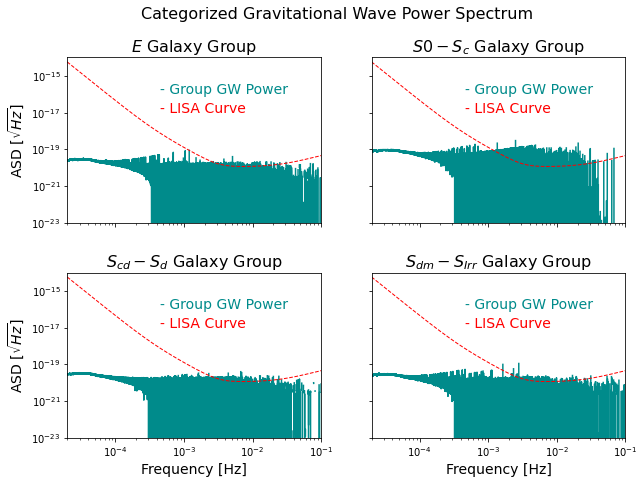

Group Power Spectrum Figure Saved.
Computing Full Power Spectrum...
Group binaries: 385817 1531893 426128 450353 
 Total binaries: 25239975
File saved as: full_power_tot_rand.h5


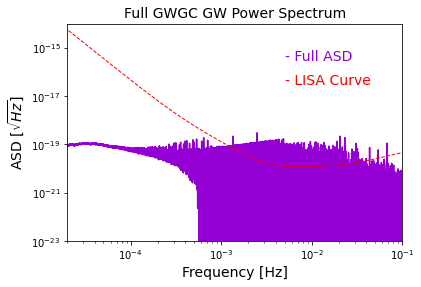

Randomized Full Power Spectrum Figure Saved


<Figure size 432x288 with 0 Axes>

In [13]:
# ==================================
# Plotting randomized Power Spectrum
# (Group and total)
# ==================================

# Import Data
data_path = './generated_data/'
LISA_PSD = GW_calcs.lisa_PSD()
g1_power_tot = pd.read_hdf(data_path + 'group_power_rand_1.h5', key='power')
g2_power_tot = pd.read_hdf(data_path + 'group_power_rand_2.h5', key='power')
g3_power_tot = pd.read_hdf(data_path + 'group_power_rand_3.h5', key='power')
g4_power_tot = pd.read_hdf(data_path + 'group_power_rand_4.h5', key='power')
print('Data imported.', '\n')

# Figure Parameters
fs = 14 # fontsize
fig, ((ax1, ax2), 
      (ax3, ax4)) = plt.subplots(2, 2, sharey = False, 
                                 gridspec_kw={'hspace': 0.3, 'wspace': 0.2}, figsize = (10, 7))
fig.suptitle('Categorized Gravitational Wave Power Spectrum', fontsize = fs+2)

# Plotting Style
g_powers = [g1_power_tot, g2_power_tot, g3_power_tot, g4_power_tot]
glx_names = ['$E$', '$S0 - S_c$', '$S_{cd} - S_d$','$S_{dm} - S_{Irr}$']
axs = [ax1, ax2, ax3, ax4]
text_x = 4.5e-4 # text location
text_y_up = 1e-16 # text location
text_y_dn = 1e-17 # text location
fs = 14 # fontsize
ax3.set_xlabel('Frequency [Hz]', fontsize=fs)
ax4.set_xlabel('Frequency [Hz]', fontsize=fs)
ax1.set_ylabel('ASD [$\sqrt{Hz}$]', fontsize=fs)
ax3.set_ylabel('ASD [$\sqrt{Hz}$]', fontsize=fs)

# Plot the Grid
for i in range(4):
    axs[i].plot(g_powers[i].f_gw, 
               (g_powers[i].strain_2*Tobs*yr_sec)**0.5, color='darkcyan', rasterized=True)
    axs[i].plot(np.linspace(5e-6, 0.1, 10000), 
               (LISA_PSD(np.linspace(5e-6, 0.1, 10000)))**0.5, lw=1, linestyle='--', color='red')
    axs[i].set_title(glx_names[i]+' Galaxy Group', fontsize=fs+2)
    axs[i].text(text_x, text_y_up, 
                r'- '+'Group GW Power', color = 'darkcyan', fontsize=fs)
    axs[i].text(text_x, text_y_dn, 
                r'- LISA Curve', color = 'red', fontsize=fs)

for ax in fig.get_axes():
    ax.label_outer()
    ax.set_xlim(2e-5, 1e-1)
    ax.set_ylim(1e-23, 1e-14)
    ax.set_xscale('log')
    ax.set_yscale('log')

plt.show()
save_plot_name = 'Group_GW_power_spec'
plt.savefig('figures/' + save_plot_name + '.png')
print('Group Power Spectrum Figure Saved.')


# ======================
# Comoputing Total Power
# ======================
print('Computing Full Power Spectrum...')

# Combine all group spectrum
full_power_tot_rand = pd.concat(g_powers)
full_power_tot_rand.sort_values(by=['f_gw'])

LISA_freq = np.arange(1e-7, 1e-1, 1/(Tobs*yr_sec))
full_power_tot_rand['digits'] = np.digitize(full_power_tot_rand.f_gw, LISA_freq)
power = full_power_tot_rand.groupby('digits').sum()['strain_2']
power_tot = np.zeros(len(LISA_freq))
power_tot[np.array(power.index.astype(int))-1] = power
full_power_tot_rand = pd.DataFrame(np.vstack([LISA_freq, power_tot]).T, 
                                   columns=['f_gw', 'strain_2'])

print('Group binaries:',
      len(g1_power_tot), len(g2_power_tot), len(g3_power_tot), len(g4_power_tot), '\n',
      'Total binaries:',
      len(full_power_tot_rand))

# Save Data
save_data_path = './generated_data/'
full_power_tot_rand.to_hdf(save_data_path + 'full_power_tot_rand' + '.h5', key='power')
print('File saved as:', 'full_power_tot_rand.h5')

# Plotting Total Power
plt.plot(full_power_tot_rand.f_gw, 
        (full_power_tot_rand.strain_2*Tobs*yr_sec)**0.5, color='darkviolet', rasterized=True)
plt.plot(np.linspace(5e-6, 0.1, 10000), 
        (LISA_PSD(np.linspace(5e-6, 0.1, 10000)))**0.5, lw=1, linestyle='--', color='red')

# Plotting Styles
plt.xscale('log')
plt.yscale('log')
plt.xlim(2e-5, 1e-1)
plt.ylim(1e-23, 1e-14)
plt.xlabel('Frequency [Hz]', fontsize=fs)
plt.ylabel('ASD [$\sqrt{Hz}$]', fontsize=fs)
plt.text(0.5e-2, 3e-16, r'- Full ASD', color = 'darkviolet', fontsize=fs)
plt.text(0.5e-2, 3e-17, r'- LISA Curve', color = 'red', fontsize=fs)
plt.title('Full GWGC GW Power Spectrum', fontsize=fs)

plt.show()
save_plot_name = 'Full_GW_power_spec_rand'
plt.savefig('figures/' + save_plot_name + '.png')
print('Randomized Full Power Spectrum Figure Saved')

Total frequencies = 1088242 

Computing Running Median...
Running Median Done. 

Saving power running median data...
Running median data saved! 

Plotting...
Figure saved as Full_GW_power_median


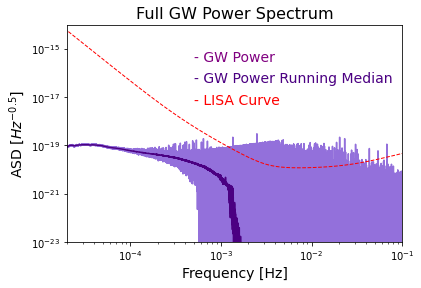

In [14]:
# =============================
# Power Spectrum Running Median
# =============================

save_data_path = './generated_data/'
full_power_tot = pd.read_hdf(save_data_path + 'full_power_tot_rand.h5', key='power')
full_power_tot['ASD'] = (full_power_tot.strain_2*Tobs*yr_sec)**0.5
full_power_tot['hf_2'] = full_power_tot.ASD**2
full_power_tot = full_power_tot[full_power_tot['ASD'] > 0]
print('Total frequencies =', len(full_power_tot), '\n')

# Computing Running Median
win = 500 # Running median window width
print('Computing Running Median...')
full_PSD_median = full_power_tot.rolling(window=win).median()
full_PSD_median = full_PSD_median[win:]
print('Running Median Done.', '\n')

# Save Running Median Data
print('Saving power running median data...')
full_PSD_median.to_csv(save_data_path + 'full_PSD_median.csv')
print('Running median data saved!', '\n')

# Plotting running median
print('Plotting...')
fs = 14 # <====== fontsize
plt.plot(full_power_tot.f_gw, full_power_tot.ASD, color='mediumpurple', rasterized=True)
plt.plot(full_PSD_median.f_gw, full_PSD_median.hf_2**0.5, color = 'indigo')
plt.plot(np.linspace(5e-6, 0.1, 10000), 
        (LISA_PSD(np.linspace(5e-6, 0.1, 10000)))**0.5, lw=1, linestyle='--', color='red')

xlabel = 5e-4 # Label x-asix location
plt.text(xlabel, 3e-16, r'- GW Power', color = 'purple', fontsize=fs)
plt.text(xlabel, 4e-17, r'- GW Power Running Median', color = 'indigo', fontsize=fs)
plt.text(xlabel, 5e-18, r'- LISA Curve', color = 'red', fontsize=fs)
plt.xscale('log')
plt.yscale('log')
plt.xlim(2e-5, 1e-1)
plt.ylim(1e-23, 1e-14)
plt.xlabel('Frequency [Hz]', fontsize=fs)
plt.ylabel('ASD [$Hz^{-0.5}$]', fontsize=fs)
plt.title('Full GW Power Spectrum', fontsize=fs+2)

save_plot_name = 'Full_GW_power_median'
plt.savefig('figures/' + save_plot_name + '.png')
print('Figure saved as', save_plot_name)
plt.show()

Computing MW PSD Running Median...
Running Median Done. 

Saving MW power running median data...
Running median data saved! 

Plotting...
Figure saved as Comparison_GW_power_median


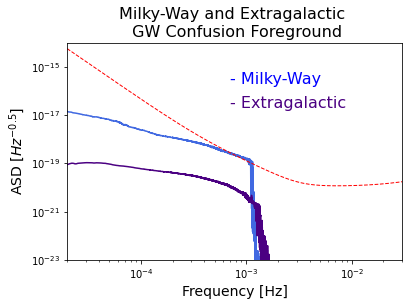

In [63]:
# =======================================
# MW - EG Confusion Foreground Comparison
# =======================================

# Extragalactic GW Data
eg_data_path = './generated_data/'
eg_PSD_median = pd.read_csv(eg_data_path + 'full_PSD_median.csv')

# MW GW Data(From COSMIC)
mw_data_path = './DATA/'
mw_power_tot = pd.read_hdf(mw_data_path+'dat_power_total.h5', key='power')
mw_power_tot = mw_power_tot.loc[mw_power_tot.strain_2 > 0]

# MW PSD Running Median
win = 500 # Running median window width
print('Computing MW PSD Running Median...')
mw_PSD_median = mw_power_tot.rolling(window=win).median()
mw_PSD_median = mw_PSD_median[win:]
print('Running Median Done.', '\n')

# Save MW Running Median Data
print('Saving MW power running median data...')
mw_PSD_median.to_csv('./generated_data/' + 'MW_full_PSD_median.csv')
print('Running median data saved!', '\n')

# =======================
# Plotting running median
# =======================

print('Plotting...')
fs = 14 # <====== fontsize
plt.plot(mw_PSD_median.f_gw, (mw_PSD_median.strain_2*Tobs*yr_sec)**0.5, color='royalblue')
plt.plot(eg_PSD_median.f_gw, eg_PSD_median.hf_2**0.5, color = 'indigo')

plt.plot(np.linspace(5e-6, 0.1, 10000), 
        (LISA_PSD(np.linspace(5e-6, 0.1, 10000)))**0.5, lw=1, linestyle='--', color='red')

xlabel = 7e-4 # Label x-asix location
plt.text(xlabel, 2e-16, r'- Milky-Way', color = 'blue', fontsize=fs+2)
plt.text(xlabel, 2e-17, r'- Extragalactic', color = 'indigo', fontsize=fs+2)
plt.xscale('log')
plt.yscale('log')
plt.xlim(2e-5, 3e-2)
plt.ylim(1e-23, 1e-14)
plt.xlabel('Frequency [Hz]', fontsize=fs)
plt.ylabel('ASD [$Hz^{-0.5}$]', fontsize=fs)
plt.title('Milky-Way and Extragalactic \n GW Confusion Foreground', fontsize=fs+2)

save_plot_name = 'Comparison_GW_power_median'
plt.savefig('figures/' + save_plot_name + '.png')
print('Figure saved as', save_plot_name)
plt.show()